@chhy

In [27]:
# This script represent a standard template for SWAXS data analysis at Formax

# The template contains a sequence of standard data processing steps as follow:

# 1. Import the necessary libraries

# 2. set the data location and save location 

proposal = '20230882'
sub_folder = '2023061608'
sample_name = 'fresh'

root_path = '/data/visitors/formax/' + proposal + '/' + sub_folder + '/'
raw_data_path = root_path + 'raw/'
azint_data_path = root_path + 'process/azint'


save_root_path = './results/' + sample_name 

# 3. set the scan number and background scan
# if only one scan for the sample, scan_start = scan_end

scan_start = 1007
scan_end = 1010
exclude_num = [1008, 1009, 1010]

bg_scan = 0  # if bo background scan, put bg_scan=0
background_substracted = 1 # no background correction = 0

# 4. load the data, both 1d & 2d, substract the background & save the data
# notice that the background substraction only done with azint data
bg_scale = 1
##for saxs: 0; for waxs: 1
waxs = 0

if waxs:
    detector = 'lambda'
    str_='WAXS'
else:    
    detector = 'eiger'
    str_='SAXS'
# check the substraction for 1d and 2d data?
check_substraction=1

# 5. average (integrate) all the scans in raw and azint data

# 6. map for according to the background-substracted azint data
snake = 0
## here you can select a roi on q range and plot the map

### 1. Import the necessary libraries

In [28]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py 
import hdf5plugin
import os, sys

def assemble_frame(modules, config):
    len_images = len(modules.shape)
    if len_images == 3:
        img = np.full(config['full_shape'], -1, dtype=np.float64)
        for i in range(4):
            module = np.rot90(modules[i], - config['rotation'][i] // 90)
            img[config['y'][i]:config['y'][i] + module.shape[0], config['x'][i]:config['x'][i]+module.shape[1]] = module
    else:
        img = []
        for j in range(len_images):
            img_ = np.full(config['full_shape'], -1, dtype=np.float64)
            module_ = modules[j]
            for i in range(4):
                module = np.rot90(module_[i], - config['rotation'][i] // 90)
                img_[config['y'][i]:config['y'][i] + module.shape[0], config['x'][i]:config['x'][i]+module.shape[1]] = module
                img.append(img_)
    return img

def average_lambda(fname, average=True):
    fh = h5py.File(fname, 'r')
    config = {}
    for key in ['full_shape', 'x', 'y', 'rotation']:
        config[key] = fh['entry/instrument/lambda/%s' %key][()]
    images = fh['entry/instrument/lambda/data'][()]
    
    if average:
        avg = None
        for img in images:
            if avg is None:
                avg = img
            else:
                avg += img
    else: 
        avg = images
    fh.close()
    return assemble_frame(avg, config) 

### 2. Data directories & save location

In [29]:
print('The root path is: ' + root_path)
print('The raw data path is: ' + raw_data_path)
print('The azint data path is: ' + azint_data_path)

try:
    os.mkdir(save_root_path)
except:
    print('Save path folder is already created!')

The root path is: /data/visitors/formax/20230882/2023061608/
The raw data path is: /data/visitors/formax/20230882/2023061608/raw/
The azint data path is: /data/visitors/formax/20230882/2023061608/process/azint
Save path folder is already created!


### 3. Set the scan number & background scan

In [30]:
scan_num = np.arange(scan_start,scan_end+1).tolist()
for number in exclude_num:
    scan_num.remove(number)
print(scan_num)

if background_substracted:
    print('The background scan is %i'%bg_scan)
else: 
    print('no background substraction would be performed')


[1007]
The background scan is 0


### 4. load the data, perform background substraction 

In [31]:
# load the background scan:
if bg_scan !=0:
    fh_bg_azint = h5py.File(os.path.join(azint_data_path, 'scan-%04d_%s_integrated.h5' %(bg_scan, detector)))

    ## check the data structure first, sometimes it has different structure
    #I_bg_1d = fh_bg_azint['entry/data1d'][:]
    #I_bg_2d = fh_bg_azint['entry/data2d/I'][:]

    I_bg_2d = np.mean(fh_bg_azint['I'][:], axis=0)
    I_bg_2d = I_bg_2d[np.newaxis, :, :]
else: 
    I_bg_2d = 0
    I_bg_1d = 0

In [32]:
# load the scan data 2D (&1D) and perform the substraction 

data_azint = []
data_azint_sub = []
data_raw = []
map_shape = []

for k, scan in enumerate(scan_num):
    print('loading scan #%04d'%scan)
    try:
        fh = h5py.File(os.path.join(azint_data_path, 'scan-%04d_%s_integrated.h5' %(scan, detector)))
        fh_raw = h5py.File(os.path.join(raw_data_path, 'scan-%04d.h5' %scan))
        raw_file_name = raw_data_path + 'scan-%04d.h5' %scan
    except Exception as e:
        print('Skipping scan %04d, error message %s' % (scan , e))
    
    q = fh['q'][:]
    I = fh['I'][:]
    if waxs:
        raw_I = average_lambda(raw_file_name, average=False)
    else:
        raw_I = fh_raw['entry/measurement/%s'%detector][:]
        
    I_substract = I - bg_scale * I_bg_2d
    
    title = fh_raw['entry/title'][()]
    print(title)
    map_shape_ = (int((str(title).split(' '))[8]) + 1, int((str(title).split(' '))[4]) + 1)
    map_shape.append(map_shape_)
    
    data_azint.append(I)
    data_azint_sub.append(I_substract)
    data_raw.append(raw_I)

loading scan #1007
b'dmesh swaxs_x -0.25 0.25 20 sc_swaxs_y 2.0 2.5 20 0.5 False'


In [33]:
data_azint = np.array(data_azint)
data_azint_sub = np.array(data_azint_sub)
data_raw = np.array(data_raw)
map_shape = np.array(map_shape)

np.savez(save_root_path + '/data_azint_%s.npz'%str_, data=data_azint, q = q, shape=map_shape)
np.savez(save_root_path + '/data_azint_sub_%s.npz'%str_, data=data_azint_sub, q = q, shape=map_shape)
np.savez(save_root_path + '/data_raw_%s.npz'%str_, data=data_raw, q = q, shape=map_shape)

In [34]:
# check substraction 
avg_data_azint = np.sum(data_azint, axis=(0,1))
avg_data_azint_sub = np.sum(data_azint_sub, axis=(0,1))
avg_data_raw = np.sum(data_raw, axis=(0,1))
print(avg_data_raw.shape)
avg_data_azint_1d = np.sum(avg_data_azint, axis=0)
avg_data_azint_sub_1d = np.sum(avg_data_azint_sub, axis=0)

(2162, 2068)


/tmp/ipykernel_4800/3359972988.py:5: RuntimeWarning: divide by zero encountered in log10
  ax[0,0].imshow(np.log10(avg_data_azint))
/tmp/ipykernel_4800/3359972988.py:12: RuntimeWarning: divide by zero encountered in log10
  ax[0,1].imshow(np.log10(avg_data_azint_sub))


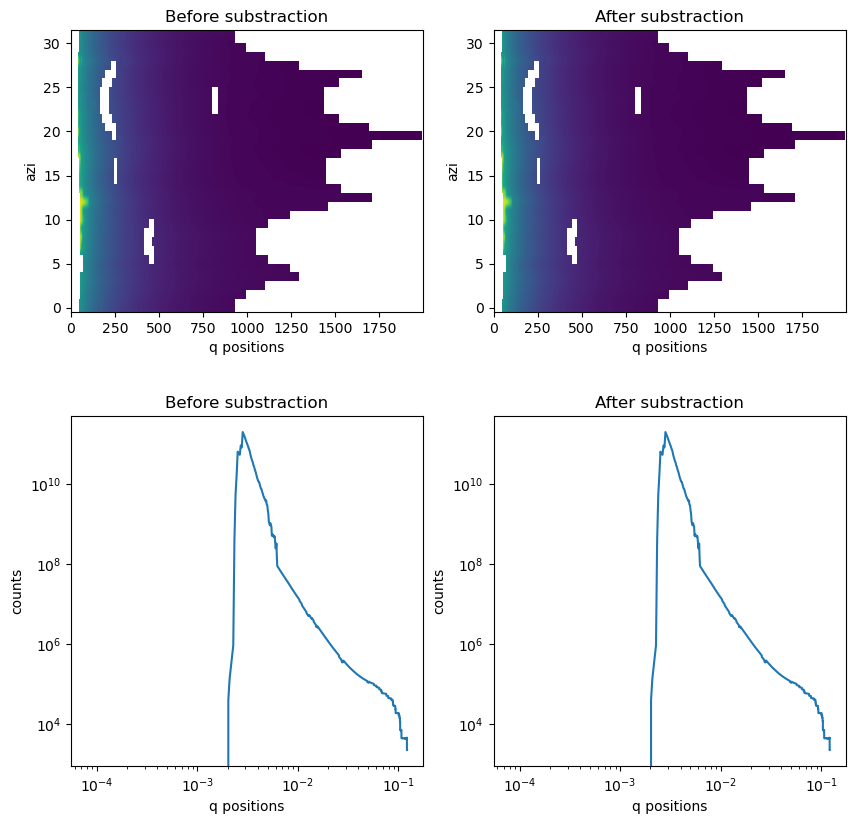

In [35]:
if check_substraction:
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    ax[0,0].set_title ('Before substraction')
    ax[0,0].imshow(np.log10(avg_data_azint))
    ax[0,0].set_ylabel('azi')
    ax[0,0].set_xlabel('q positions')
    ax[0,0].set_aspect(50)
    ax[0,0].invert_yaxis()
    
    ax[0,1].set_title ('After substraction')
    ax[0,1].imshow(np.log10(avg_data_azint_sub))
    ax[0,1].set_ylabel('azi')
    ax[0,1].set_xlabel('q positions')
    ax[0,1].set_aspect(50)
    ax[0,1].invert_yaxis()
    
    ax[1,0].set_title ('Before substraction')
    ax[1,0].plot(q, avg_data_azint_1d)
    ax[1,0].set_ylabel('counts')
    ax[1,0].set_xlabel('q positions')
    ax[1,0].set_yscale('log')
    ax[1,0].set_xscale('log')
    #ax[1,0].set_aspect(50)
    
    ax[1,1].set_title ('After substraction')
    ax[1,1].plot(q, avg_data_azint_sub_1d)
    ax[1,1].set_ylabel('counts')
    ax[1,1].set_xlabel('q positions')
    ax[1,1].set_yscale('log')
    ax[1,1].set_xscale('log')
    #ax[1,1].set_aspect(50)


### 5. Averaging (integrating) the data

/tmp/ipykernel_4800/75522591.py:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].imshow(np.log10(avg_data_azint_sub))


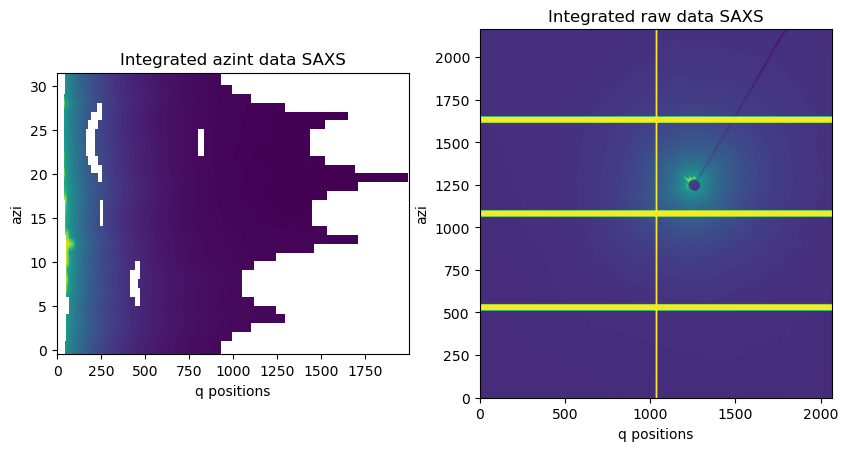

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].set_title ('Integrated azint data %s'%str_)
ax[0].imshow(np.log10(avg_data_azint_sub))
ax[0].set_ylabel('azi')
ax[0].set_xlabel('q positions')
ax[0].set_aspect(50)
ax[0].invert_yaxis()

ax[1].set_title ('Integrated raw data %s'%str_)
ax[1].imshow(np.log10(avg_data_raw))
ax[1].set_ylabel('azi')
ax[1].set_xlabel('q positions')
#ax[1].set_aspect(50)
ax[1].invert_yaxis()

### 6. mapping

(441,)


Text(0, 0.5, 'y range / mm')

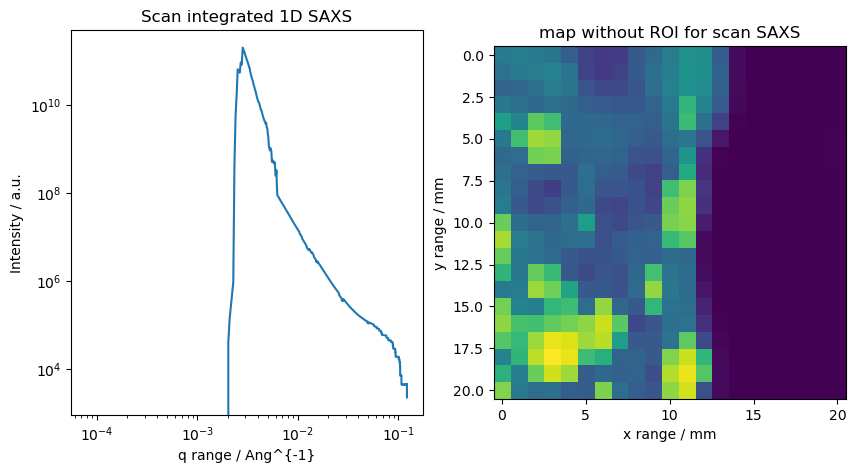

In [37]:
# the original map without any roi
map_shape_ = map_shape[0]
ori_map_data = []
for i in range(data_azint_sub.shape[0]):
    data_azint_sub_ = data_azint_sub[i]
    map_data_ = np.sum(data_azint_sub_, axis=(1, 2))
    print(map_data_.shape)
    map_data_ = map_data_.reshape(map_shape_)
    if snake:
        map_data_[1::2]=map_data_[1::2,::-1]
    ori_map_data.append(map_data_)

ori_map_data=np.array(ori_map_data)
np.savez(save_root_path + '/data_map.npz', data=ori_map_data)

int_ori_map_data = np.sum(ori_map_data, axis=0)
int_ori_map_data = np.swapaxes(int_ori_map_data, 1, 0)

fig,axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(q, avg_data_azint_sub_1d)
axs[0].set_title('Scan integrated 1D %s'%str_)
axs[0].set_xlabel('q range / Ang^{-1}')
axs[0].set_ylabel('Intensity / a.u.')
axs[0].set_yscale('log')
axs[0].set_xscale('log')

axs[1].imshow(np.flip(np.log10(int_ori_map_data), axis = 0))
axs[1].set_title('map without ROI for scan %s'%str_)
axs[1].set_xlabel('x range / mm')
axs[1].set_ylabel('y range / mm')

In [38]:
# roi mapping 
ROI_range = [1, 2]
dpixel = np.searchsorted(q, ROI_range)
print(dpixel)

selected_map_data = data_azint_sub[:,:,:,dpixel]
selected_map_data = np.sum(selected_map_data, axis=(0,2,3))
selected_map_data = selected_map_data.reshape(map_shape_)

if snake:
    selected_map_data[1::2] = selected_map_data[1::2,::-1]
selected_map_data = np.swapaxes(selected_map_data, 1, 0)


fig,axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(q, avg_data_azint_sub_1d)
axs[0].set_title('Scan integrated 1D %s'%str_)
axs[0].set_xlabel('q range / Ang^{-1}')
axs[0].set_ylabel('Intensity / a.u.')
axs[0].axvline(ROI_range[0], 0, 10, color='red')
axs[0].axvline(ROI_range[1], 0, 10, color='red')

axs[1].imshow(np.flip(np.log10(selected_map_data), axis = 0))
axs[1].set_title('map with ROI for scan %s'%str_)
axs[1].set_xlabel('x range / mm')
axs[1].set_ylabel('y range / mm')


[2000 2000]


IndexError: index 2000 is out of bounds for axis 3 with size 2000